Timeseries Plot For Multiple Model Builds

In [71]:
library(readr)
library(dplyr)
library(tidyr)
library(stringr)
library(magrittr)
library(padr)
library(kableExtra)
library(purrr)
library(ggplot2)
library(ggthemr)
library(here)
library(lubridate)
library(caret)
library(scales)
ggthemr("fresh")
devtools::load_all()

select_season <- "alnu20"


Loading CHAPo



In [72]:
load(paste0(here(), "/data/other/species.RData"))
load(paste0(here(), "/data/other/stations.RData"))

In [73]:


data_dwh <- import_data_dwh(paste0(here(), "/data/dwh/pollen_dwh_hourly.txt"))

if (select_season == "alnu20") {
  data_osm <- import_data_cosmo("/scratch/sadamov/wd/20_alnu_osm/mod_pollen_combined.txt", type = "Operational - C1E")
  data_pheno_v1 <- import_data_cosmo("/scratch/sadamov/wd/20_alnu_pheno_v1/mod_pollen_combined.txt", type = "Phenology V1")
  data_pheno_v2 <- import_data_cosmo("/scratch/sadamov/wd/20_alnu_pheno_v2/mod_pollen_combined.txt", type = "Phenology V2")
  data_pheno_v3 <- import_data_cosmo("/scratch/sadamov/wd/20_alnu_pheno_v3/mod_pollen_combined.txt", type = "Phenology V3")
  data_pheno_v4 <- import_data_cosmo("/scratch/sadamov/wd/20_alnu_pheno_v4/mod_pollen_combined.txt", type = "Phenology V4")
  data_pheno_v1 %<>% mutate(value = 0.6 * value)
  data_pheno_v2 %<>% mutate(value = 0.6 * value)
  data_pheno_v3 %<>% mutate(value = 0.6 * value)
  data_pheno_v4 %<>% mutate(value = 0.6 * value)
} else if (select_season == "alnu19") {
  data_osm <- import_data_cosmo("/scratch/sadamov/wd/19_alnu_osm/mod_pollen_combined.txt", type = "Operational - C1E")
  data_pheno_v1 <- import_data_cosmo("/scratch/sadamov/wd/19_alnu_pheno_v1/mod_pollen_combined.txt", type = "Phenology V1")
  data_pheno_v2 <- import_data_cosmo("/scratch/sadamov/wd/19_alnu_pheno_v2/mod_pollen_combined.txt", type = "Phenology V2")
  data_pheno_v1 %<>% mutate(value = 0.6 * value)
  data_pheno_v2 %<>% mutate(value = 0.6 * value)
} else if (select_season == "alnu21") {
  data_osm <- import_data_cosmo("/scratch/sadamov/wd/21_alnu_osm/mod_pollen_combined.txt", type = "Operational - C1E")
  data_pheno_v3 <- import_data_cosmo("/scratch/sadamov/wd/21_alnu_pheno_v3/mod_pollen_combined.txt", type = "Phenology V3")
  data_pheno_v3 %<>% mutate(value = 0.6 * value)
} else if (select_season == "betu20") {
  data_osm <- import_data_cosmo("/scratch/sadamov/wd/20_betu_osm/mod_pollen_combined.txt", type = "Operational - C1E")
  data_pheno_v1 <- import_data_cosmo("/scratch/sadamov/wd/20_betu_pheno_v1/mod_pollen_combined.txt", type = "Phenology V1")
  data_pheno_v2 <- import_data_cosmo("/scratch/sadamov/wd/20_betu_pheno_v2/mod_pollen_combined.txt", type = "Phenology V2")
  data_pheno_v3 <- import_data_cosmo("/scratch/sadamov/wd/20_betu_pheno_v3/mod_pollen_combined.txt", type = "Phenology V3")
} else if (select_season == "betu19") {
  data_osm <- import_data_cosmo("/scratch/sadamov/wd/19_betu_osm/mod_pollen_combined.txt", type = "Operational - C1E")
  data_pheno_v1 <- import_data_cosmo("/scratch/sadamov/wd/19_betu_pheno_v1/mod_pollen_combined.txt", type = "Phenology V1")
  data_pheno_v2 <- import_data_cosmo("/scratch/sadamov/wd/19_betu_pheno_v2/mod_pollen_combined.txt", type = "Phenology V2")
} else if (select_season == "poac20") {
  data_osm <- import_data_cosmo("/scratch/sadamov/wd/20_poac_osm/mod_pollen_combined.txt", type = "Operational - C1E")
  data_pheno_v1 <- import_data_cosmo("/scratch/sadamov/wd/20_poac_pheno_v1/mod_pollen_combined.txt", type = "Phenology V1")
  data_pheno_v2 <- import_data_cosmo("/scratch/sadamov/wd/20_poac_pheno_v2/mod_pollen_combined.txt", type = "Phenology V2")
  data_pheno_v3 <- import_data_cosmo("/scratch/sadamov/wd/20_poac_pheno_v3/mod_pollen_combined.txt", type = "Phenology V3")
} else if (select_season == "poac19") {
  data_osm <- import_data_cosmo("/scratch/sadamov/wd/19_poac_osm/mod_pollen_combined.txt", type = "Operational - C1E")
  data_pheno_v1 <- import_data_cosmo("/scratch/sadamov/wd/19_poac_pheno_v1/mod_pollen_combined.txt", type = "Phenology V1")
  data_pheno_v2 <- import_data_cosmo("/scratch/sadamov/wd/19_poac_pheno_v2/mod_pollen_combined.txt", type = "Phenology V2")
}

data_list <- list(
  dwh = data_dwh,
  osm = data_osm,
  pheno_v1 = data_pheno_v1,
  pheno_v2 = data_pheno_v2,
  pheno_v3 = data_pheno_v3
  # pheno_v4 = data_pheno_v4
)

data_daily_list <- map(data_list, ~ .x %>%
  aggregate_pollen() %>%
  impute_daily() %>%
  filter(measurement == "concentration"))

data_daily <- data_daily_list %>% bind_rows()

data_daily_comp <- map(data_daily_list[-1], ~ data_daily_list$dwh %>%
  select(date, taxon, station, obs = value) %>%
  right_join(.x, by = c("taxon", "date", "station")) %>%
  select(date, taxon, station, obs, value))


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  PARAMETER = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  PARAMETER = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  PARAMETER = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [74]:
if (select_season == "alnu20") {
  data_osm_sdes <- import_data_cosmo("/scratch/sadamov/wd/20_alnu_osm/mod_sdes_combined.txt", type = "Operational - C1E")
  data_pheno_v1_sdes <- import_data_cosmo("/scratch/sadamov/wd/20_alnu_pheno_v1/mod_sdes_combined.txt", type = "Phenology V1")
  data_pheno_v2_sdes <- import_data_cosmo("/scratch/sadamov/wd/20_alnu_pheno_v2/mod_sdes_combined.txt", type = "Phenology V2")
  data_pheno_v3_sdes <- import_data_cosmo("/scratch/sadamov/wd/20_alnu_pheno_v3/mod_sdes_combined.txt", type = "Phenology V3")
  data_pheno_v4_sdes <- import_data_cosmo("/scratch/sadamov/wd/20_alnu_pheno_v4/mod_sdes_combined.txt", type = "Phenology V4")
} else if (select_season == "alnu19") {
  data_osm_sdes <- import_data_cosmo("/scratch/sadamov/wd/19_alnu_osm/mod_sdes_combined.txt", type = "Operational - C1E")
  data_pheno_v1_sdes <- import_data_cosmo("/scratch/sadamov/wd/19_alnu_pheno_v1/mod_sdes_combined.txt", type = "Phenology V1")
  data_pheno_v2_sdes <- import_data_cosmo("/scratch/sadamov/wd/19_alnu_pheno_v2/mod_sdes_combined.txt", type = "Phenology V2")
} else if (select_season == "alnu21") {
  data_osm_sdes <- import_data_cosmo("/scratch/sadamov/wd/21_alnu_osm/mod_sdes_combined.txt", type = "Operational - C1E")
  data_pheno_v3_sdes <- import_data_cosmo("/scratch/sadamov/wd/21_alnu_pheno_v3/mod_sdes_combined.txt", type = "Phenology V3")
} else if (select_season == "betu20") {
  data_osm_sdes <- import_data_cosmo("/scratch/sadamov/wd/20_betu_osm/mod_sdes_combined.txt", type = "Operational - C1E")
  data_pheno_v1_sdes <- import_data_cosmo("/scratch/sadamov/wd/20_betu_pheno_v1/mod_sdes_combined.txt", type = "Phenology V1")
  data_pheno_v2_sdes <- import_data_cosmo("/scratch/sadamov/wd/20_betu_pheno_v2/mod_sdes_combined.txt", type = "Phenology V2")
  data_pheno_v3_sdes <- import_data_cosmo("/scratch/sadamov/wd/20_betu_pheno_v3/mod_sdes_combined.txt", type = "Phenology V3")
} else if (select_season == "betu19") {
  data_osm_sdes <- import_data_cosmo("/scratch/sadamov/wd/19_betu_osm/mod_sdes_combined.txt", type = "Operational - C1E")
  data_pheno_v1_sdes <- import_data_cosmo("/scratch/sadamov/wd/19_betu_pheno_v1/mod_sdes_combined.txt", type = "Phenology V1")
  data_pheno_v2_sdes <- import_data_cosmo("/scratch/sadamov/wd/19_betu_pheno_v2/mod_sdes_combined.txt", type = "Phenology V2")
} else if (select_season == "poac20") {
  data_osm_sdes <- import_data_cosmo("/scratch/sadamov/wd/20_poac_osm/mod_sdes_combined.txt", type = "Operational - C1E")
  data_pheno_v1_sdes <- import_data_cosmo("/scratch/sadamov/wd/20_poac_pheno_v1/mod_sdes_combined.txt", type = "Phenology V1")
  data_pheno_v2_sdes <- import_data_cosmo("/scratch/sadamov/wd/20_poac_pheno_v2/mod_sdes_combined.txt", type = "Phenology V2")
  data_pheno_v3_sdes <- import_data_cosmo("/scratch/sadamov/wd/20_poac_pheno_v3/mod_sdes_combined.txt", type = "Phenology V3")
} else if (select_season == "poac19") {
  data_osm_sdes <- import_data_cosmo("/scratch/sadamov/wd/19_poac_osm/mod_sdes_combined.txt", type = "Operational - C1E")
  data_pheno_v1_sdes <- import_data_cosmo("/scratch/sadamov/wd/19_poac_pheno_v1/mod_sdes_combined.txt", type = "Phenology V1")
  data_pheno_v2_sdes <- import_data_cosmo("/scratch/sadamov/wd/19_poac_pheno_v2/mod_sdes_combined.txt", type = "Phenology V2")
}

data_pheno_v4_sdes_list <- list()
data_pheno_v3_sdes_list <- list()
data_pheno_v2_sdes_list <- list()
data_pheno_v1_sdes_list <- list()
data_osm_sdes_list <- list()

data_osm_sdes %<>%
  aggregate_pollen() %>%
  impute_daily()

for (stn in stations$station) {
  max_value <- data_daily_list$osm %>%
    filter(station == stn) %>%
    pull(value) %>%
    max()
  data_osm_sdes_list[[stn]] <- data_osm_sdes %>%
    filter(station == stn) %>%
    mutate(value = rescale(value, to = c(0, 1.2 * max_value)))
}

data_osm_sdes <- data_osm_sdes_list %>%
  bind_rows()

data_pheno_v2_sdes %<>%
  aggregate_pollen() %>%
  impute_daily()

for (stn in stations$station) {
  max_value <- data_daily_list$osm %>%
    filter(station == stn) %>%
    pull(value) %>%
    max()
  data_pheno_v2_sdes_list[[stn]] <- data_pheno_v2_sdes %>%
    filter(station == stn) %>%
    mutate(value = rescale(value, to = c(0, 1.2 * max_value)))
}

data_pheno_v2_sdes <- data_pheno_v2_sdes_list %>%
  bind_rows()
  
  
data_pheno_v1_sdes %<>%
  aggregate_pollen() %>%
  impute_daily()

for (stn in stations$station) {
  max_value <- data_daily_list$osm %>%
    filter(station == stn) %>%
    pull(value) %>%
    max()
  data_pheno_v1_sdes_list[[stn]] <- data_pheno_v1_sdes %>%
    filter(station == stn) %>%
    mutate(value = rescale(value, to = c(0, 1.2 * max_value)))
}

data_pheno_v1_sdes <- data_pheno_v1_sdes_list %>%
  bind_rows()

data_pheno_v3_sdes %<>%
  aggregate_pollen() %>%
  impute_daily()

for (stn in stations$station) {
  max_value <- data_daily_list$osm %>%
    filter(station == stn) %>%
    pull(value) %>%
    max()
  data_pheno_v3_sdes_list[[stn]] <- data_pheno_v3_sdes %>%
    filter(station == stn) %>%
    mutate(value = rescale(value, to = c(0, 1.2 * max_value)))
}

data_pheno_v3_sdes <- data_pheno_v3_sdes_list %>%
  bind_rows()

data_pheno_v4_sdes %<>%
  aggregate_pollen() %>%
  impute_daily()

for (stn in stations$station) {
  max_value <- data_daily_list$osm %>%
    filter(station == stn) %>%
    pull(value) %>%
    max()
  data_pheno_v4_sdes_list[[stn]] <- data_pheno_v4_sdes %>%
    filter(station == stn) %>%
    mutate(value = rescale(value, to = c(0, 1.2 * max_value)))
}

data_pheno_v4_sdes <- data_pheno_v4_sdes_list %>%
  bind_rows()
    
    


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  PARAMETER = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  PARAMETER = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  PARAMETER = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────

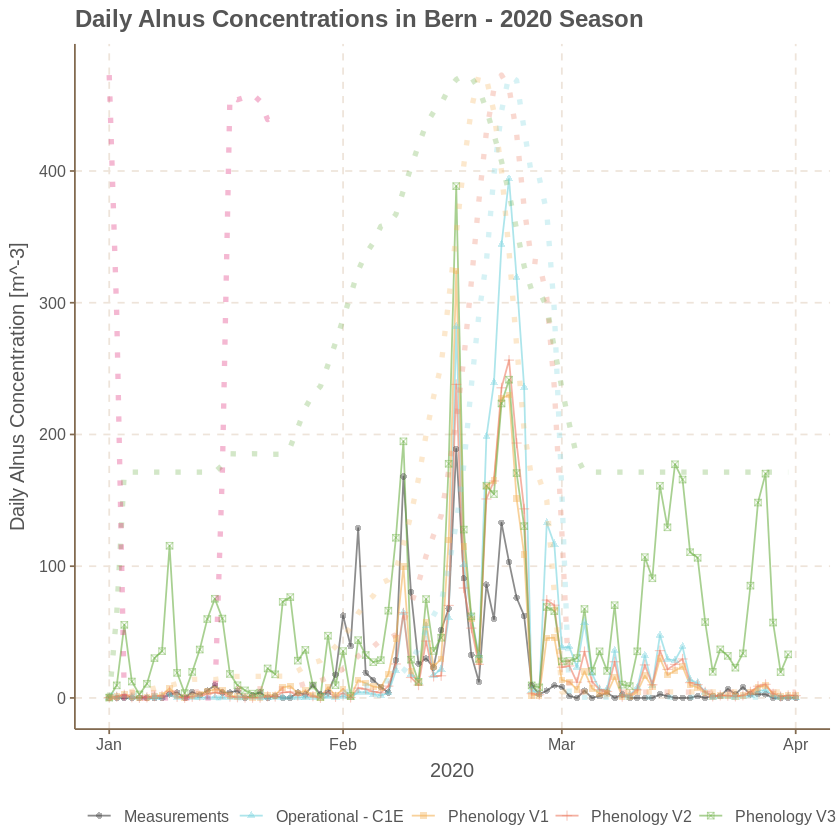

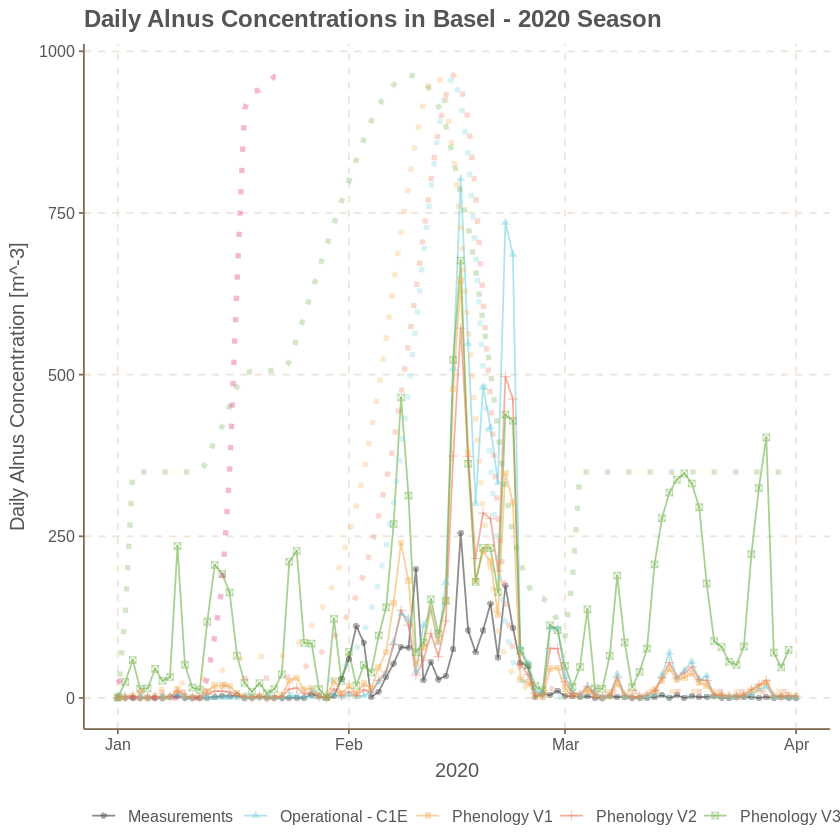

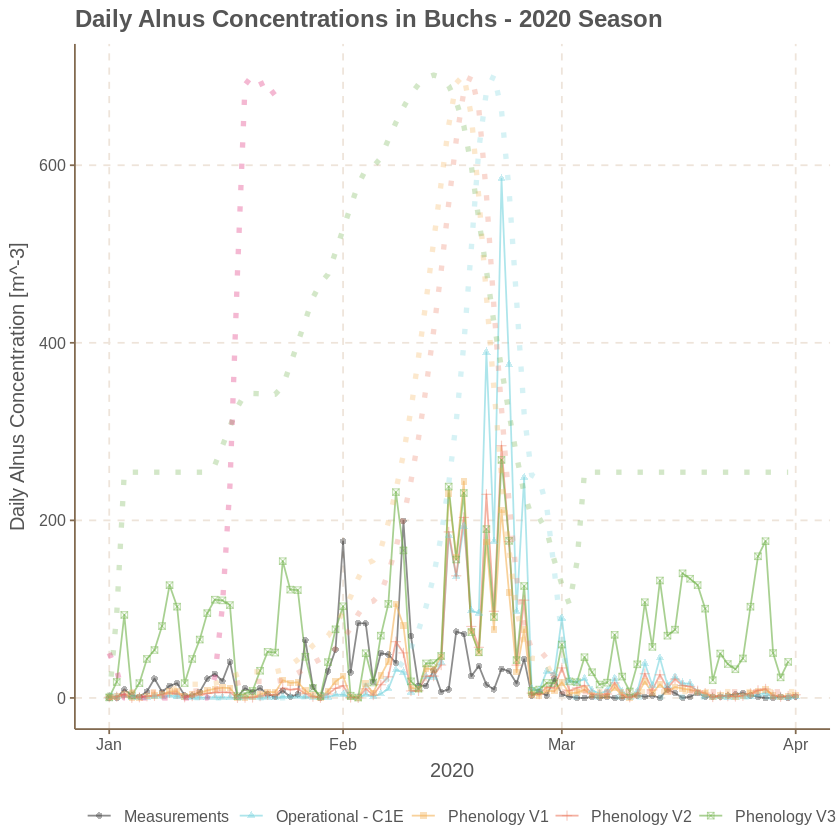

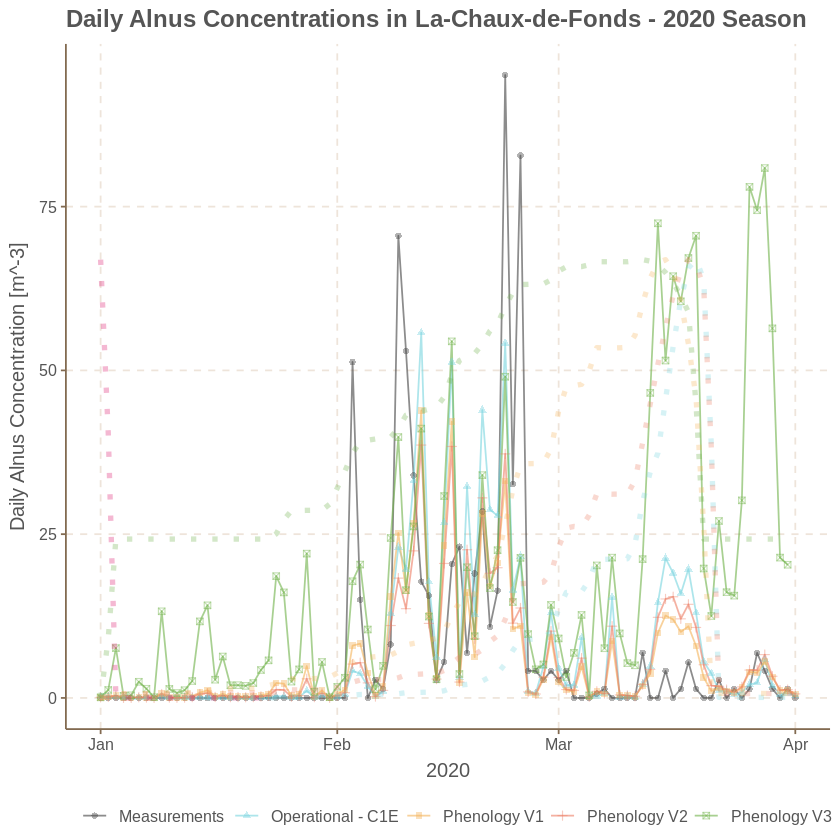

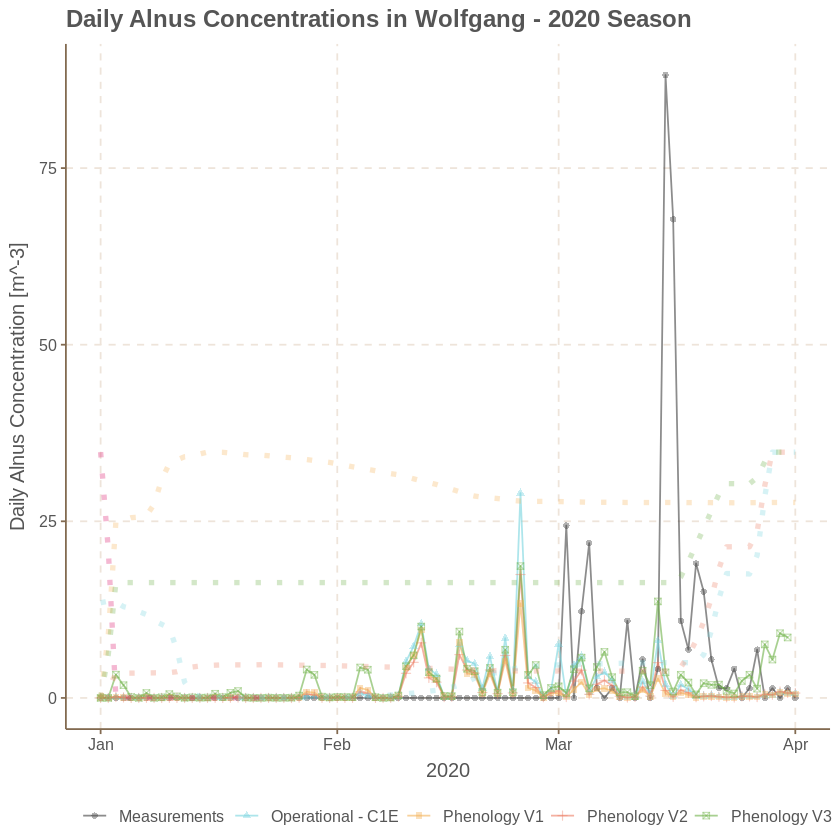

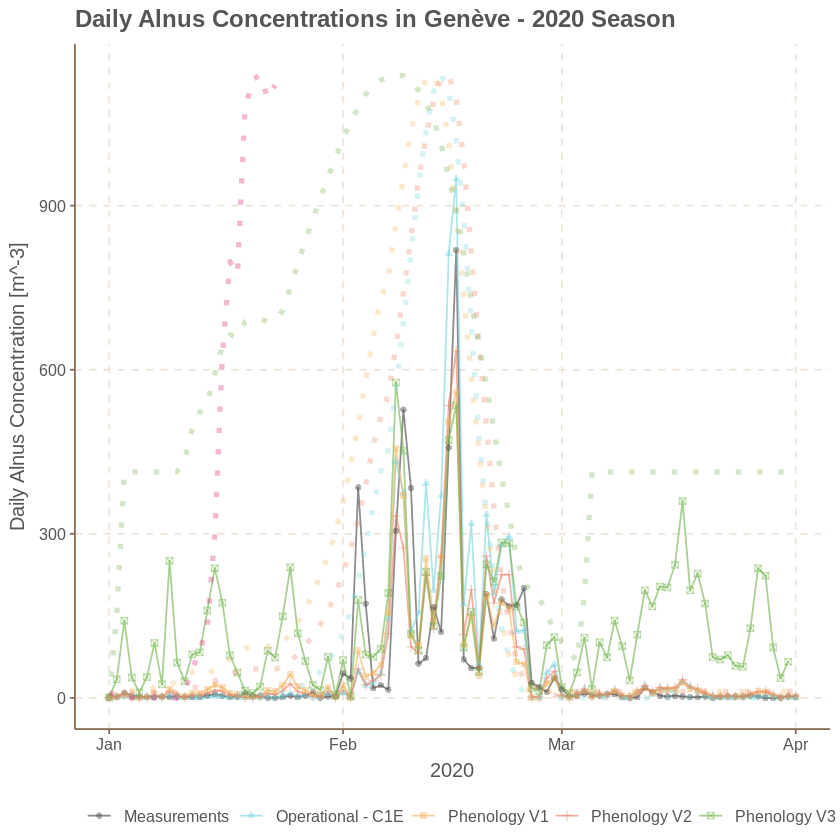

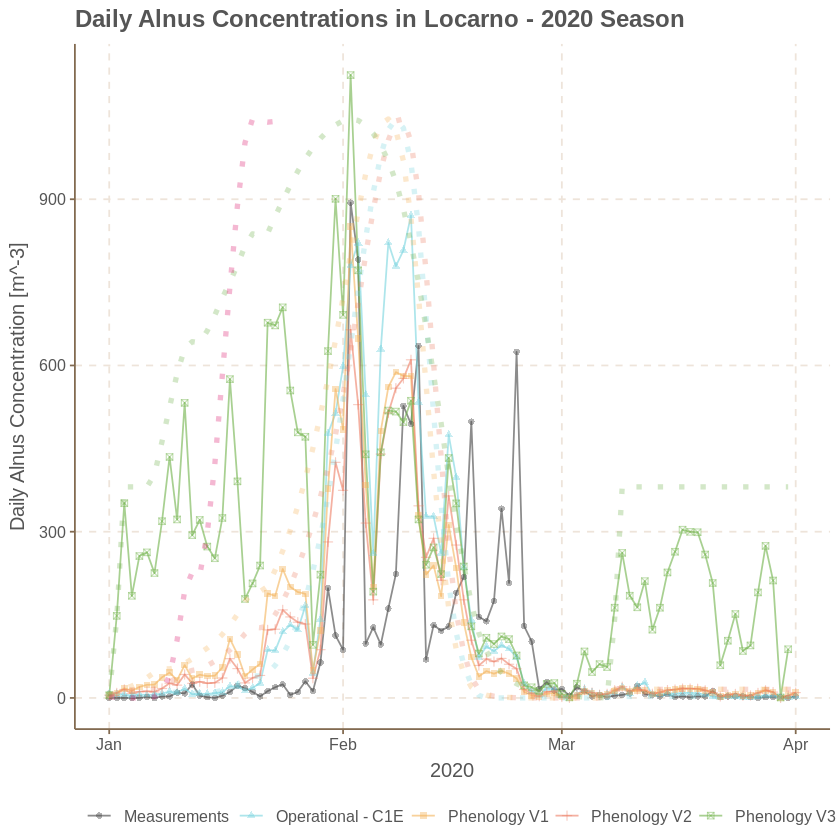

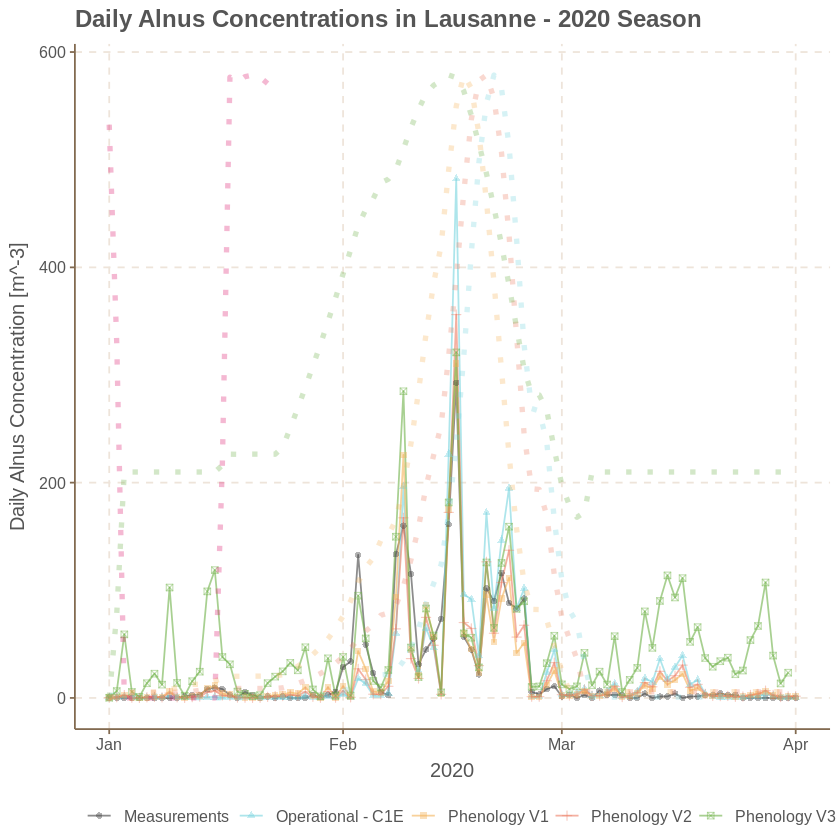

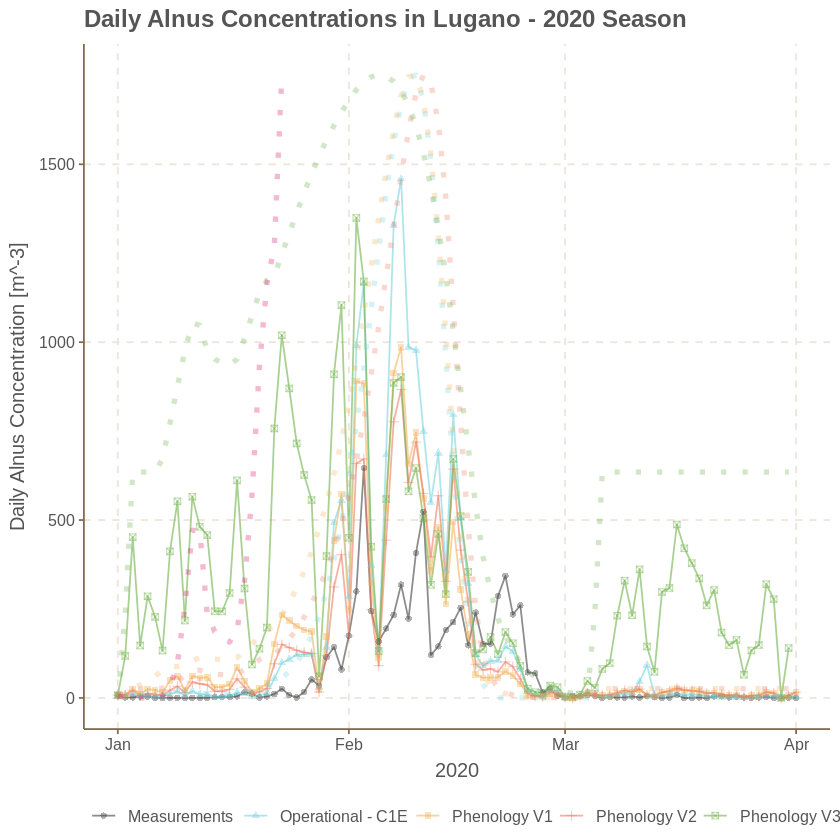

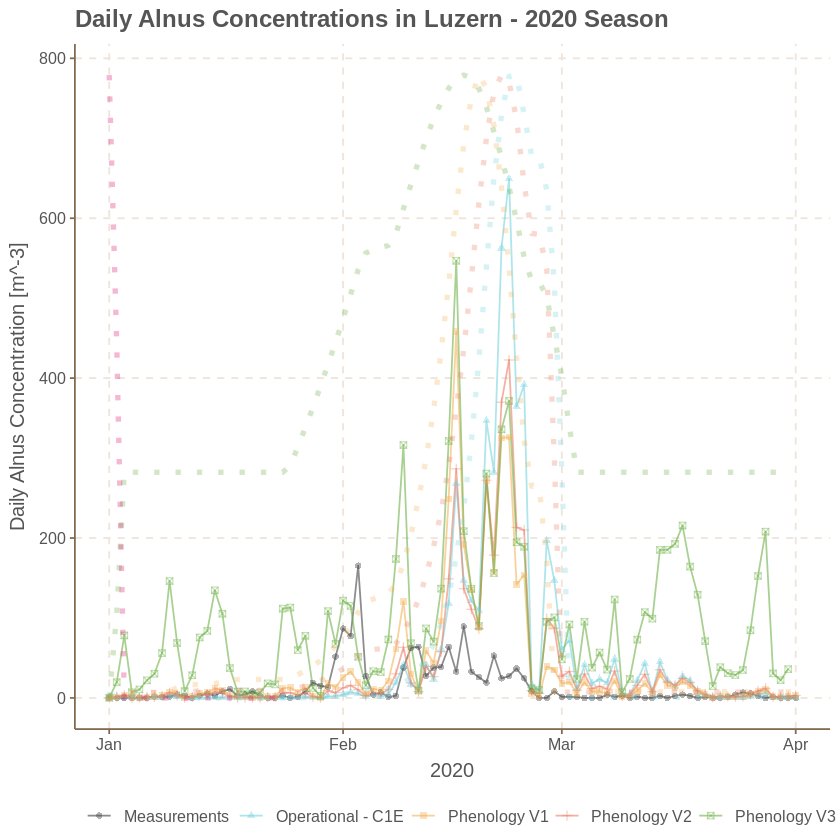

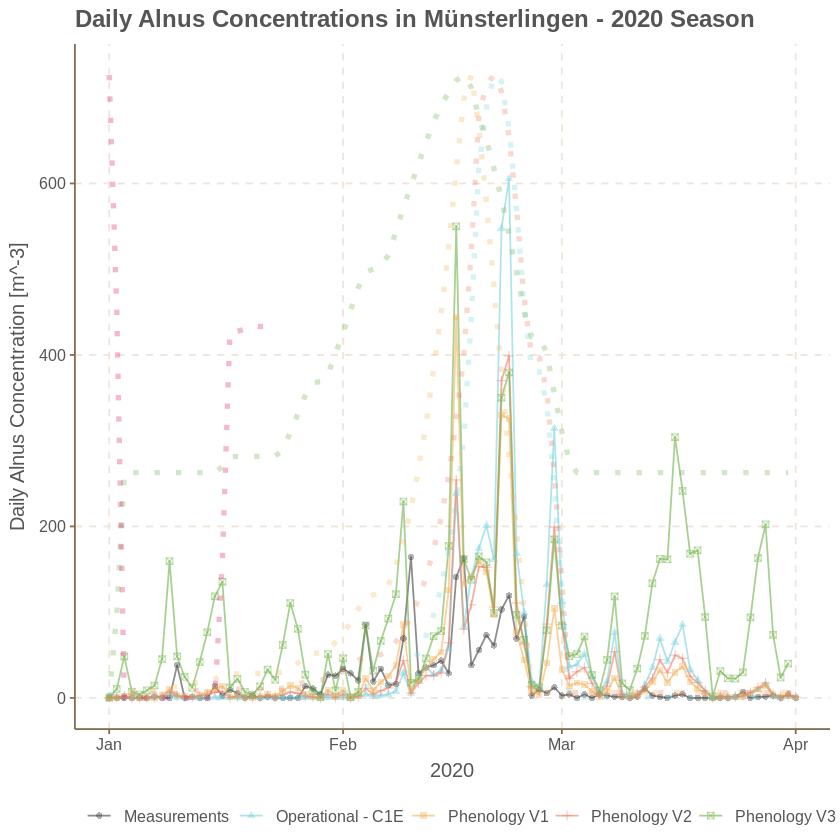

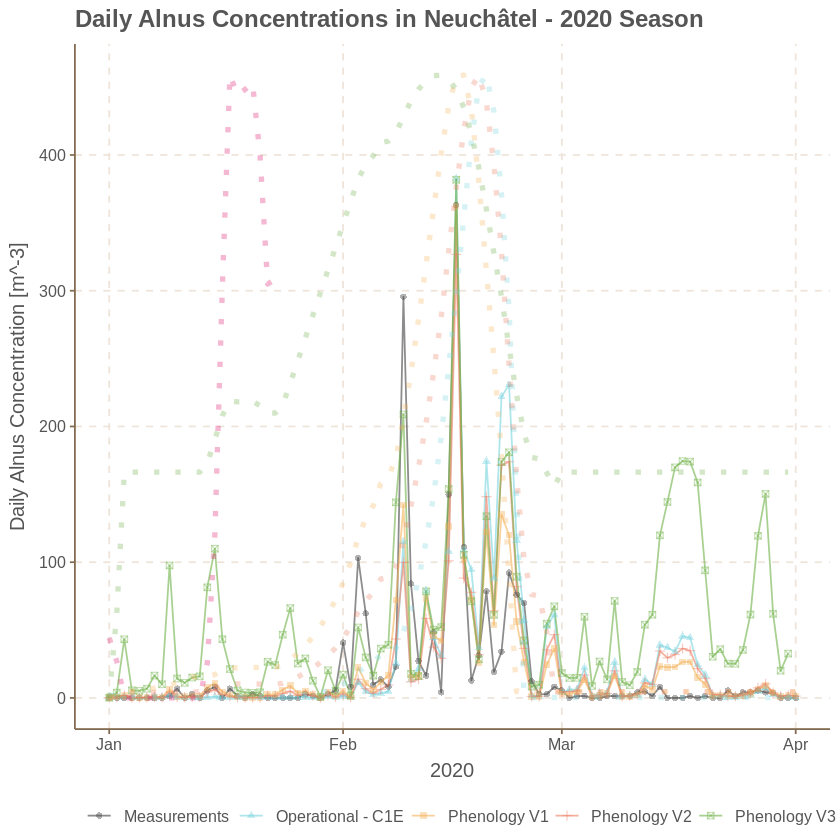

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]

[[12]]

[[13]]

[[14]]


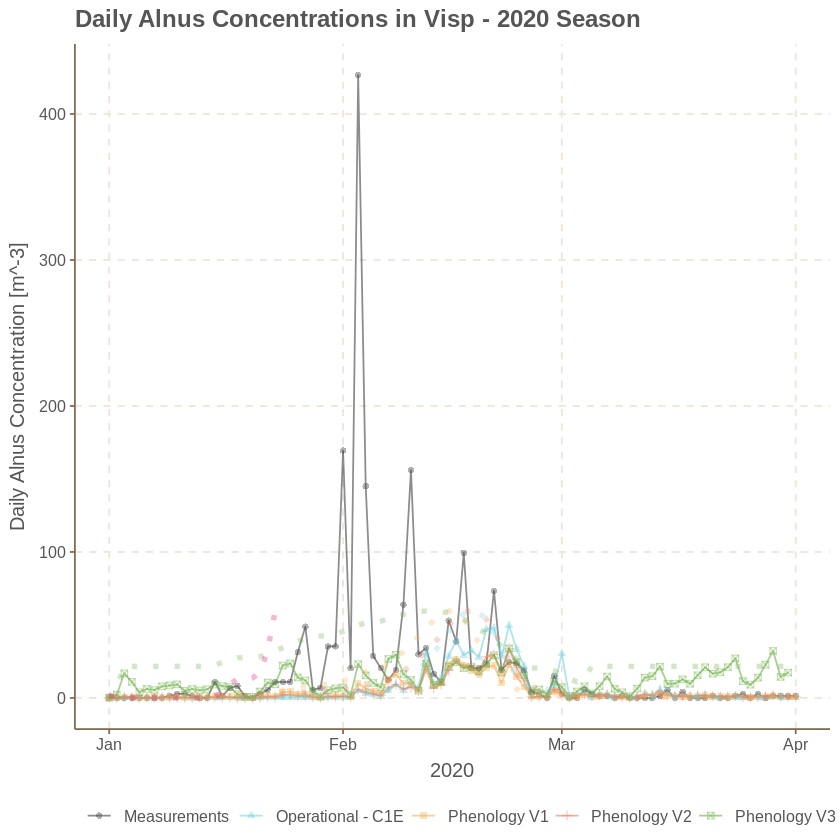

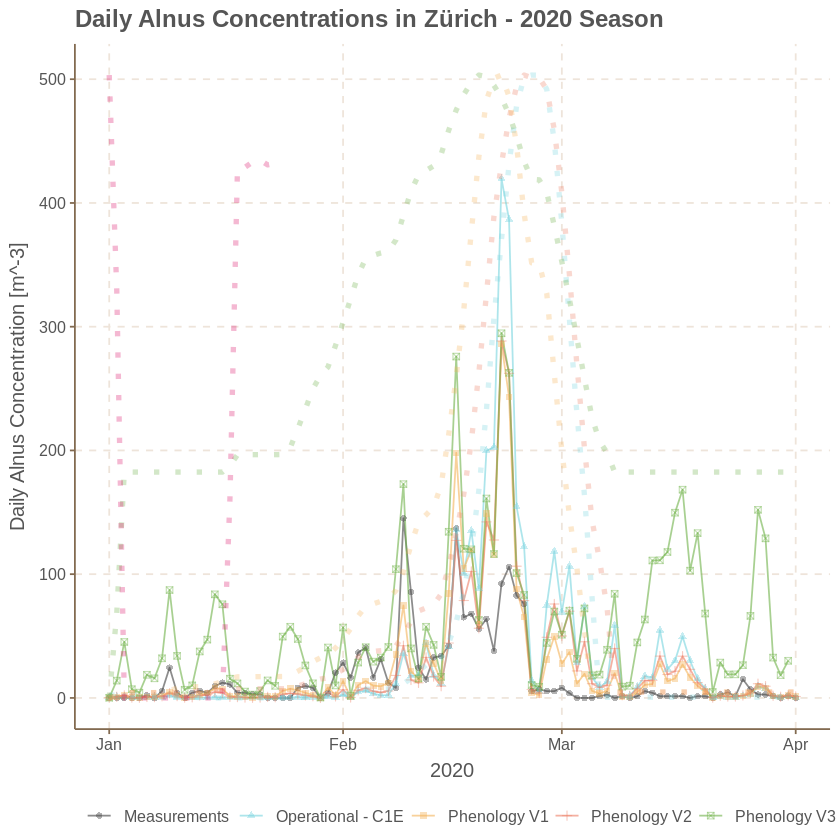

In [75]:
taxon_selected <- data_list$osm %>%
  pull(taxon) %>%
  unique()
start_date <- data_list$osm %>%
  pull(date) %>%
  min()
end_date <- data_list$osm %>%
  pull(date) %>%
  max()
year_selected <- year(start_date)

map(stations$station, ~
data_daily %>%
  filter(
    taxon == taxon_selected,
    station == .x,
    between(date, start_date, end_date)
  ) %>%
  ggplot() +
  geom_line(aes(x = date, y = value, col = type), alpha = 0.6) +
  geom_point(aes(x = date, y = value, col = type, shape = type), alpha = 0.4) +
  geom_line(data = data_osm_sdes %>%
    filter(
      taxon == taxon_selected,
      station == .x,
      between(date, start_date, end_date)
    ), aes(x = date, y = value), col = "#76d3de", size = 1.5, alpha = 0.3, lty = 3) +
  geom_line(data = data_pheno_v2_sdes %>%
    filter(
      taxon == taxon_selected,
      station == .x,
      between(date, start_date, end_date)
    ), aes(x = date, y = value), col = "#ec7d64", size = 1.5, alpha = 0.3, lty = 3) +
  geom_line(data = data_pheno_v1_sdes %>%
    filter(
      taxon == taxon_selected,
      station == .x,
      between(date, start_date, end_date)
    ), aes(x = date, y = value), col = "#f4b258", size = 1.5, alpha = 0.3, lty = 3) +
  geom_line(data = data_pheno_v3_sdes %>%
    filter(
      taxon == taxon_selected,
      station == .x,
      between(date, start_date, end_date)
    ), aes(x = date, y = value), col = "#6eb148", size = 1.5, alpha = 0.3, lty = 3) +
    geom_line(data = data_pheno_v4_sdes %>%
    filter(
      taxon == taxon_selected,
      station == .x,
      between(date, start_date, end_date)
    ), aes(x = date, y = value), col = "#db146a", size = 1.5, alpha = 0.3, lty = 3) +
  scale_color_manual(values = c("#404040", "#76d3de", "#f4b258", "#ec7d64", "#6eb148", "#db146a", "#52cdb5")) +
  # scale_color_manual(values = swatch()[c(3, 2, 4, 5, 9, 7)]) +
  theme(legend.position = "bottom", legend.title = element_blank()) +
  xlab(year_selected) +
  ylab(paste("Daily", taxon_selected, "Concentration [m^-3]")) +
  ggtitle(paste0("Daily ", taxon_selected, " Concentrations in ", .x, " - ", year_selected, " Season")))

# ggsave(paste0(here(), "/vignettes/figures/timeseries.png"), gg_timeseries, width = 24, height = 13.5, dpi = 300, units = c("cm"))

In the following we are looking at several numeric and categoric metrics to compare the new model builds.

In [76]:
metrics_numeric <- map(data_daily_comp, ~ .x  %>%
  filter(obs >= 10
    # , date < as.Date("2020-07-31")
    ) %>% 
  summarise(
    R2 = cor(value, obs, use = "complete.obs")^2,
    ME = mean(abs((value - obs)), na.rm = TRUE),
    SDME = sd(abs((value - obs)), na.rm = TRUE),
    MSE = mean((value - obs)^2, na.rm = TRUE),
    RMSE = sqrt(MSE),
    MSLE = mean((log(1 + value) - log(1 + obs))^2, na.rm = TRUE),
    RMSLE = sqrt(MSLE),
    MAE = mean(abs(value - obs), na.rm = TRUE)
  ))

metrics_numeric %<>%
  bind_rows() %>%
  mutate(model = names(metrics_numeric))

mse_baseline <- metrics_numeric %>%
  filter(model == "osm") %>%
  pull(MSE)

metrics_numeric %<>%
  mutate("Rel. MSE" = MSE / mse_baseline)

metrics_numeric  %>%
  arrange(MSE) %>%
  kable() %>%
  kable_styling("striped", full_width = FALSE) %>%
  as.character() %>%
  IRdisplay::display_html()

R2,ME,SDME,MSE,RMSE,MSLE,RMSLE,MAE,model,Rel. MSE
0.3766060,77.85499,99.80592,15997.53,126.4813,2.112799,1.453547,77.85499,pheno_v2,0.4235575
0.3728043,81.10638,109.21808,18476.79,135.9293,1.887824,1.373981,81.10638,pheno_v1,0.4891994
0.3555044,109.33040,160.87727,37769.44,194.3436,2.772856,1.665189,109.33040,osm,1.0000000
0.2482653,112.19172,164.48561,39574.35,198.9330,1.758892,1.326232,112.19172,pheno_v3,1.0477875



Reference	
Predicted	Event	No Event
Event	A	B
No Event	C	D
The formulas used here are:

Sensitivity = A/(A+C)

Specificity = D/(B+D)

Prevalence = (A+C)/(A+B+C+D)

PPV = (sensitivity * prevalence)/((sensitivity*prevalence) + ((1-specificity)*(1-prevalence)))

NPV = (specificity * (1-prevalence))/(((1-sensitivity)*prevalence) + ((specificity)*(1-prevalence)))

Detection Rate = A/(A+B+C+D)

Detection Prevalence = (A+B)/(A+B+C+D)

Balanced Accuracy = (sensitivity+specificity)/2

Precision = A/(A+B)

Recall = A/(A+C)

F1 = (1+beta^2)*precision*recall/((beta^2 * precision)+recall)

In [77]:
data_valid <- map(data_daily_comp, ~ .x %>%
  # filter(date < as.Date("2020-07-31")) %>%
  mutate(
    conc_obs = case_when(
      taxon == "Alnus" & obs < 1 ~ "nothing",
      taxon == "Alnus" & obs >= 1 & obs <= 10 ~ "weak",
      taxon == "Alnus" & obs >= 11 & obs <= 69 ~ "medium",
      taxon == "Alnus" & obs >= 70 & obs <= 249 ~ "strong",
      taxon == "Alnus" & obs >= 250 ~ "verystrong",
      taxon == "Betula" & obs < 1 ~ "nothing",
      taxon == "Betula" & obs >= 1 & obs <= 10 ~ "weak",
      taxon == "Betula" & obs >= 11 & obs <= 69 ~ "medium",
      taxon == "Betula" & obs >= 70 & obs <= 299 ~ "strong",
      taxon == "Betula" & obs >= 300 ~ "verystrong",
      taxon == "Poaceae" & obs < 1 ~ "nothing",
      taxon == "Poaceae" & obs >= 1 & obs <= 19 ~ "weak",
      taxon == "Poaceae" & obs >= 20 & obs <= 49 ~ "medium",
      taxon == "Poaceae" & obs >= 50 & obs <= 149 ~ "strong",
      taxon == "Poaceae" & obs >= 150 ~ "verystrong",
      taxon == "Ambrosia" & obs < 1 ~ "nothing",
      taxon == "Ambrosia" & obs >= 1 & obs <= 5 ~ "weak",
      taxon == "Ambrosia" & obs >= 6 & obs <= 10 ~ "medium",
      taxon == "Ambrosia" & obs >= 11 & obs <= 39 ~ "strong",
      taxon == "Ambrosia" & obs >= 40 ~ "verystrong"
    ),
    conc_value = case_when(
      taxon == "Alnus" & value < 1 ~ "nothing",
      taxon == "Alnus" & value >= 1 & value <= 10 ~ "weak",
      taxon == "Alnus" & value >= 11 & value <= 69 ~ "medium",
      taxon == "Alnus" & value >= 70 & value <= 249 ~ "strong",
      taxon == "Alnus" & value >= 250 ~ "verystrong",
      taxon == "Betula" & value < 1 ~ "nothing",
      taxon == "Betula" & value >= 1 & value <= 10 ~ "weak",
      taxon == "Betula" & value >= 11 & value <= 69 ~ "medium",
      taxon == "Betula" & value >= 70 & value <= 299 ~ "strong",
      taxon == "Betula" & value >= 300 ~ "verystrong",
      taxon == "Poaceae" & value < 1 ~ "nothing",
      taxon == "Poaceae" & value >= 1 & value <= 19 ~ "weak",
      taxon == "Poaceae" & value >= 20 & value <= 49 ~ "medium",
      taxon == "Poaceae" & value >= 50 & value <= 149 ~ "strong",
      taxon == "Poaceae" & value >= 150 ~ "verystrong",
      taxon == "Ambrosia" & value < 1 ~ "nothing",
      taxon == "Ambrosia" & value >= 1 & value <= 5 ~ "weak",
      taxon == "Ambrosia" & value >= 6 & value <= 10 ~ "medium",
      taxon == "Ambrosia" & value >= 11 & value <= 39 ~ "strong",
      taxon == "Ambrosia" & value >= 40 ~ "verystrong"
    )
  ) %>%
  mutate_at(
    vars(conc_obs, conc_value),
    ~ factor(., levels = c("nothing", "weak", "medium", "strong", "verystrong"))) %>% 
  filter(!(conc_obs %in% c("nothing", "weak"))))

confusion_matrix <- map(data_valid, ~ confusionMatrix(.x$conc_value, .x$conc_obs))

metrics_categoric  <- confusion_matrix %>%
  map(~ .x$overall[1:2]) %>%
  bind_rows() %>%
  mutate(model = names(confusion_matrix))

kappa_baseline <- metrics_categoric %>%
  filter(model == "osm") %>%
  pull(Kappa)

accuracy_baseline <- metrics_categoric %>%
  filter(model == "osm") %>%
  pull(Accuracy)

kable_metrics_categoric <- metrics_categoric %>%
  mutate("Rel. Accuracy" = Accuracy / accuracy_baseline,
         "Rel. Kappa" = Kappa / kappa_baseline) %>%
  arrange(desc(Kappa)) %>%
  kable() %>%
  kable_styling("striped", full_width = FALSE)

kable_metrics_categoric %>%
  as.character() %>%
  IRdisplay::display_html()

Accuracy,Kappa,model,Rel. Accuracy,Rel. Kappa
0.4712329,0.2018197,pheno_v3,1.284546,1.2905160
0.3989071,0.1617390,pheno_v2,1.087391,1.0342239
0.3668478,0.1563868,osm,1.000000,1.0000000
0.4166667,0.1515532,pheno_v1,1.135803,0.9690922


In [78]:
confusion_matrix

$osm
Confusion Matrix and Statistics

            Reference
Prediction   nothing weak medium strong verystrong
  nothing          0    0     33      2          0
  weak             0    0     58     14          1
  medium           0    0     74     20          1
  strong           0    0     39     43          8
  verystrong       0    0     13     44         18

Overall Statistics
                                          
               Accuracy : 0.3668          
                 95% CI : (0.3175, 0.4184)
    No Information Rate : 0.5897          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1564          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: nothing Class: weak Class: medium Class: strong
Sensitivity                      NA          NA        0.3410        0.3496
Specificity                 0.90489      0.8016     

In [79]:
save_kable(kable_metrics_categoric, file = paste0(here(), "/vignettes/tables/test.html"))